In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
from utilities3 import *

import operator
from functools import reduce
from functools import partial

from timeit import default_timer

from Adam import Adam
torch.manual_seed(0)
np.random.seed(0)

In [2]:
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x


In [3]:
class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the coefficient function and locations (u0(x, 0), v0(x, 0), x, t)
        input shape: (batchsize, x=s, t=0, c=4)
        output: the solution 
        output shape: (batchsize, x=s, t=3, c=2)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 18  # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(4, self.width)  # input channel is 3: (u0(x, 1), u1(x, 1), x, t)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        x = F.pad(x, [self.padding, self.padding, self.padding, self.padding])

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x[..., :-2*self.padding, :-2*self.padding]
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

In [4]:


ntrain = 1000
ntest = 200

modes = 12
width = 32

batch_size = 20


epochs = 500
learning_rate = 0.001
scheduler_step = 100
scheduler_gamma = 0.5

print(epochs, learning_rate, scheduler_step, scheduler_gamma)





t1 = default_timer()


sub = 1
S = 256 // sub
T_in = 1




data = scipy.io.loadmat('../Data/NLSG.mat')
t = data['t']
data = data['u']

T = t.shape[1] - T_in
train_a = data[:ntrain,::sub,:T_in]
train_a_m = torch.from_numpy(np.real(train_a))
train_a_n = torch.from_numpy(np.imag(train_a))
# train_a_m = train_a_m.reshape(ntrain,S,T_in,1)
# train_a_n = train_a_n.reshape(ntrain,S,T_in,1)
train_a = torch.cat((train_a_m,train_a_n), dim=-1)
train_a = train_a.type(torch.float32)

train_u = data[:ntrain,::sub,T_in:T+T_in]
train_u_m = torch.from_numpy(np.real(train_u))
train_u_n = torch.from_numpy(np.imag(train_u))
# train_u_m = train_u_m.reshape(ntrain,S,T,1)
# train_u_n = train_u_n.reshape(ntrain,S,T,1)
train_u = torch.cat((train_u_m,train_u_n), dim=-1)
train_u= train_u.type(torch.float32)

# reader = MatReader(TEST_PATH)
test_a = data[-ntest:,::sub,:T_in]
test_a_m = torch.from_numpy(np.real(test_a))
test_a_n = torch.from_numpy(np.imag(test_a))
# test_a_m = test_a_m.reshape(ntest,S,T_in,1)
# test_a_n = test_a_n.reshape(ntest,S,T_in,1)
test_a = torch.cat((test_a_m,test_a_n), dim=-1)
test_a = test_a.type(torch.float32)
#
test_u = data[-ntest:,::sub,T_in:T+T_in]
test_u_m = torch.from_numpy(np.real(test_u))
test_u_n = torch.from_numpy(np.imag(test_u))
# test_u_m = test_u_m.reshape(ntest,S,T,1)
# test_u_n = test_u_n.reshape(ntest,S,T,1)
test_u = torch.cat((test_u_m,test_u_n), dim=-1)
test_u = test_u.type(torch.float32)

print(train_a.shape,train_u.shape,test_a.shape,test_u.shape )



a_normalizer = UnitGaussianNormalizer(train_a)
train_a = a_normalizer.encode(train_a)
test_a = a_normalizer.encode(test_a)

y_normalizer = UnitGaussianNormalizer(train_u)
train_u = y_normalizer.encode(train_u)

train_a = train_a.reshape(ntrain,S,1,T_in*2).repeat([1,1,T,1])
test_a = test_a.reshape(ntest,S,1,T_in*2).repeat([1,1,T,1])
print(train_a.shape,test_a.shape)


train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_a, train_u), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=batch_size, shuffle=False)

t2 = default_timer()

print('preprocessing finished, time used:', t2-t1)
device = torch.device('cuda')

################################################################
# training and evaluation
################################################################
model = FNO2d(modes, modes, width).cuda()
# model = torch.load('model/ns_fourier_V100_N1000_ep100_m8_w20')

print(count_params(model))
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)


500 0.001 100 0.5
torch.Size([1000, 256, 2]) torch.Size([1000, 256, 198]) torch.Size([200, 256, 2]) torch.Size([200, 256, 198])
torch.Size([1000, 256, 99, 2]) torch.Size([200, 256, 99, 2])
preprocessing finished, time used: 2.591915599999999
2368162


In [5]:
MSE = []
TrainL_2 = []
TestL_2 = []
t00 = default_timer()
myloss = LpLoss(size_average=False)
y_normalizer.cuda()
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x).view(batch_size, S,  T*2)

        mse = F.mse_loss(out, y, reduction='mean')
        # mse.backward()

        y = y_normalizer.decode(y)
        out = y_normalizer.decode(out)
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward()

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()

    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x).view(batch_size, S,  T*2)
            out = y_normalizer.decode(out)
            test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest
    
    MSE.append(train_mse)
    TrainL_2.append(train_l2)
    TestL_2.append(test_l2)

    t2 = default_timer()
    print(ep, t2-t1, train_mse, train_l2, test_l2)
t01 = default_timer()
print(f"训练结束，总时长为{t01-t00}s")

0 14.067320899999999 0.7520784711837769 0.4490260443687439 0.22923603892326355
1 6.417305200000001 0.236005067974329 0.18449116778373717 0.14986902475357056
2 6.3854941000000025 0.13999456092715262 0.12736069178581239 0.10518266677856446
3 6.47807259999999 0.09445206649601459 0.09642156267166138 0.08507340848445892
4 6.506699099999992 0.07636323973536491 0.0808459233045578 0.07401662051677704
5 6.793017099999986 0.06338026113808155 0.06846116769313812 0.062238256335258486
6 7.110260600000004 0.05312487617135048 0.05855145418643951 0.054812390506267544
7 7.3169512999999995 0.04639403745532036 0.05612057107686996 0.052011068463325504
8 7.268835800000005 0.04073003612458706 0.05082531368732452 0.04745288848876953
9 7.405088999999975 0.03580475021153688 0.0443706316947937 0.042895718812942504
10 7.462457600000022 0.03188683718442917 0.04131270390748978 0.0402347531914711
11 9.62037190000001 0.028634427189826964 0.03904150104522705 0.04263001412153244
12 10.41663459999998 0.0261436019465327

99 17.65572700000007 0.003428556346334517 0.01044899071753025 0.010335247442126274
100 16.904768399999966 0.0032349074399098754 0.006534809678792953 0.005671943947672844
101 15.522455300000047 0.003111295262351632 0.005952901341021061 0.006692461781203747
102 15.558704099999886 0.003073305510915816 0.005716204673051834 0.005253332518041134
103 16.220735399999967 0.0029900555196218192 0.005243063494563102 0.0052171903103590015
104 15.544449900000018 0.002941077926661819 0.00524271397292614 0.005465034544467926
105 16.21094210000001 0.0029093643045052884 0.005306694269180298 0.005485323928296566
106 15.506488999999874 0.0028925842768512664 0.005765590943396091 0.005778544433414936
107 15.47228159999986 0.0028741369326598944 0.005745121218264103 0.006074589043855667
108 15.478382700000111 0.002856975020840764 0.005634163446724415 0.00539123423397541
109 16.225317199999836 0.00283404934220016 0.005866950415074825 0.006667851731181145
110 15.458509899999854 0.0028225796995684505 0.005591593

194 16.98711080000021 0.002161669887136668 0.004872027739882469 0.005222349390387535
195 16.226034100000106 0.0021496837586164473 0.004810278460383415 0.00611911691725254
196 15.538665600000058 0.0021959077822975813 0.00590576147288084 0.006674291603267193
197 16.408175899999605 0.0021518880850635467 0.004847000688314438 0.004550700783729553
198 15.564744400000109 0.0021513069537468254 0.004960150897502899 0.004885559231042862
199 14.811447900000076 0.0022122278297320008 0.006306215599179268 0.005026604980230331
200 17.115785100000267 0.002116735342424363 0.0037490218207240104 0.0034429090097546577
201 17.658410900000035 0.002081630842294544 0.0032786630056798457 0.00337156118825078
202 16.973858299999847 0.002062095641158521 0.003173485238105059 0.0031824281811714174
203 14.783678899999813 0.0020473402785137294 0.0031828270964324476 0.0032894836366176607
204 15.567527200000313 0.0020369476662017404 0.003292117942124605 0.0035809442773461343
205 16.30185449999999 0.002033448179718107 0

288 16.206896400000005 0.0017147988313809038 0.003599577836692333 0.0037721697613596916
289 16.172677499999736 0.0017081321100704371 0.003421809058636427 0.0038489318266510964
290 15.511713100000634 0.0017023139470256866 0.003247560050338507 0.004050486236810685
291 14.767220700000507 0.0017245600186288357 0.004060462601482868 0.004675414338707924
292 16.210052399999768 0.0017091477359645068 0.0034377587512135505 0.0030995495431125164
293 15.516045400000621 0.0016970571270212532 0.003032557278871536 0.0036443915590643884
294 14.795858800000133 0.001700150864198804 0.003366703096777201 0.004187753275036812
295 15.477040800000395 0.0016969410027377308 0.003423063840717077 0.003426276184618473
296 16.252772599999844 0.0016907143651042134 0.0032693692408502103 0.004178086407482624
297 15.503307700000732 0.0017028755089268089 0.003669134210795164 0.003625747635960579
298 16.252750899999228 0.001703184392536059 0.0035200165174901483 0.004116718359291553
299 16.22417029999997 0.00169969670241

382 16.188198400000147 0.0014897031569853425 0.002394171752035618 0.00239348104223609
383 15.71341940000002 0.001486172960139811 0.002350193418562412 0.002587692867964506
384 15.528589500000635 0.0014882369805127383 0.002536571741104126 0.002565909828990698
385 15.465916600000128 0.0014826648391317576 0.002285514324903488 0.0023194686137139797
386 16.177091700000346 0.0014807159232441336 0.002316829543560743 0.0022975299693644047
387 16.89500969999972 0.0014783603127580137 0.0022626551575958727 0.0022996007464826107
388 16.154668799999854 0.0014809079375118018 0.0023792829364538194 0.0024686582386493684
389 16.959899899999982 0.001478274593828246 0.002433744456619024 0.0024551970139145853
390 16.15200629999981 0.0014747057924978436 0.002322424545884132 0.002318548634648323
391 14.760902400000305 0.0014713224186562002 0.002225037533789873 0.0021868789568543433
392 14.761905600000318 0.0014690975262783468 0.0022434909753501417 0.002508341707289219
393 15.505724900000132 0.001474498503375

476 14.770822499999667 0.0013601827900856732 0.0019901459962129594 0.002078096382319927
477 14.836788899999192 0.0013587976258713753 0.001966567782685161 0.002007413562387228
478 16.225797299999613 0.0013568559533450753 0.0019438811913132668 0.002009796015918255
479 15.56711180000002 0.0013558352866675704 0.0019674992971122265 0.0020053281635046007
480 14.822005299999546 0.0013544719200581311 0.001970702104270458 0.002033792920410633
481 15.558494500000052 0.0013558441295754165 0.002078123401850462 0.0019774693436920643
482 15.491851699999643 0.0013527518161572515 0.00192764563113451 0.001966138128191233
483 16.21355929999936 0.0013527392409741878 0.0020207425989210606 0.002125494573265314
484 14.788765399999647 0.001354217721382156 0.002135876517742872 0.0021988113038241865
485 15.424831199999971 0.0013515358499716968 0.002033677615225315 0.0020296192914247514
486 15.516219299999648 0.001349585420684889 0.0019323497377336026 0.001967860721051693
487 16.184532999999647 0.00134860079968

In [6]:
# torch.save(model.state_dict(), 'model_fno.pth')

In [5]:
modes = 12
width = 32
model = FNO2d(modes, modes, width).cuda()
model.load_state_dict(torch.load('model_fno.pth'))
model.eval() 

FNO2d(
  (fc0): Linear(in_features=4, out_features=32, bias=True)
  (conv0): SpectralConv2d()
  (conv1): SpectralConv2d()
  (conv2): SpectralConv2d()
  (conv3): SpectralConv2d()
  (w0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (w1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (w2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (w3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=32, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [6]:
s_time = time.time()
Pred_L2 = []
pred = torch.zeros(test_u.shape)
index = 0
y_normalizer.cuda()
myloss = LpLoss(size_average=False)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=1, shuffle=False)
with torch.no_grad():
    for x, y in test_loader:
        test_l2 = 0
        x, y = x.cuda(), y.cuda()
        t1 = default_timer()
        out = model(x).view( S,  T*2)
        out = y_normalizer.decode(out)
        pred[index] = out

        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        t2 = default_timer()
        print(f"第{index+1}个样本, 时间为{t2 - t1}s, 相对L2误差为{test_l2}")
        index = index + 1
        Pred_L2.append(test_l2)

    print(f"Total Time:{time.time() - s_time:.6f}s")      


第1个样本, 时间为4.995951000000002s, 相对L2误差为0.00365660572424531
第2个样本, 时间为0.050013299999999816s, 相对L2误差为0.002775064902380109
第3个样本, 时间为0.05063559999999967s, 相对L2误差为0.0019283173605799675
第4个样本, 时间为0.04987939999999824s, 相对L2误差为0.0013677777023985982
第5个样本, 时间为0.016479800000002598s, 相对L2误差为0.0012107290094718337
第6个样本, 时间为0.002596000000000487s, 相对L2误差为0.0014458397636190057
第7个样本, 时间为0.002594999999999459s, 相对L2误差为0.0026810900308191776
第8个样本, 时间为0.0029599999999980753s, 相对L2误差为0.0019902391359210014
第9个样本, 时间为0.002576399999998813s, 相对L2误差为0.001785986707545817
第10个样本, 时间为0.0025802000000005876s, 相对L2误差为0.0017936936346814036
第11个样本, 时间为0.002550799999998077s, 相对L2误差为0.0017067521112039685
第12个样本, 时间为0.0032696000000029812s, 相对L2误差为0.0018134883139282465
第13个样本, 时间为0.002732000000001733s, 相对L2误差为0.002303273184224963
第14个样本, 时间为0.0026055000000013706s, 相对L2误差为0.002682171296328306
第15个样本, 时间为0.002773600000001153s, 相对L2误差为0.002599666826426983
第16个样本, 时间为0.0027362999999986926s, 相对L2误差为0.0014648742508143187
第17个样本, 

第135个样本, 时间为0.0029152000000003397s, 相对L2误差为0.0032485127449035645
第136个样本, 时间为0.002631000000000938s, 相对L2误差为0.0018812153721228242
第137个样本, 时间为0.002536500000001496s, 相对L2误差为0.0011576312826946378
第138个样本, 时间为0.0025511000000015827s, 相对L2误差为0.0016391318058595061
第139个样本, 时间为0.0027676999999997065s, 相对L2误差为0.0018788139568641782
第140个样本, 时间为0.002896899999999647s, 相对L2误差为0.0024880897253751755
第141个样本, 时间为0.0028116999999987513s, 相对L2误差为0.0013169385492801666
第142个样本, 时间为0.0028596999999983552s, 相对L2误差为0.0016878478927537799
第143个样本, 时间为0.0026927999999983854s, 相对L2误差为0.0027603991329669952
第144个样本, 时间为0.002519600000002953s, 相对L2误差为0.0020791348069906235
第145个样本, 时间为0.00247749999999769s, 相对L2误差为0.0011266571236774325
第146个样本, 时间为0.0024452000000003693s, 相对L2误差为0.0022192951291799545
第147个样本, 时间为0.0024407999999986885s, 相对L2误差为0.0020553693175315857
第148个样本, 时间为0.002436599999999345s, 相对L2误差为0.0019856570288538933
第149个样本, 时间为0.0024319000000012636s, 相对L2误差为0.002767958678305149
第150个样本, 时间为0.002495699999997214s

In [10]:
# scipy.io.savemat('NLSG-FNO.mat', mdict={'pred': pred.cpu().numpy(),'MSE': MSE, 'TrainL_2': TrainL_2, 'TestL_2':TestL_2, 'Pred_L2':Pred_L2})

In [8]:
data = scipy.io.loadmat('../Data/NLSG.mat')
x = data["x"]
t = data["t"]
X, T = np.meshgrid(x,t[...,1:])
print(X.shape,T.shape)

u = data['u']
a = data['a']
u = u[-ntest:,:,1:]
print(a.shape)
print(u.shape)
pred = scipy.io.loadmat('NLSG_FNO.mat')
pred = pred['pred']
pred.shape

(99, 256) (99, 256)
(1500, 1)
(200, 256, 99)


(200, 256, 198)

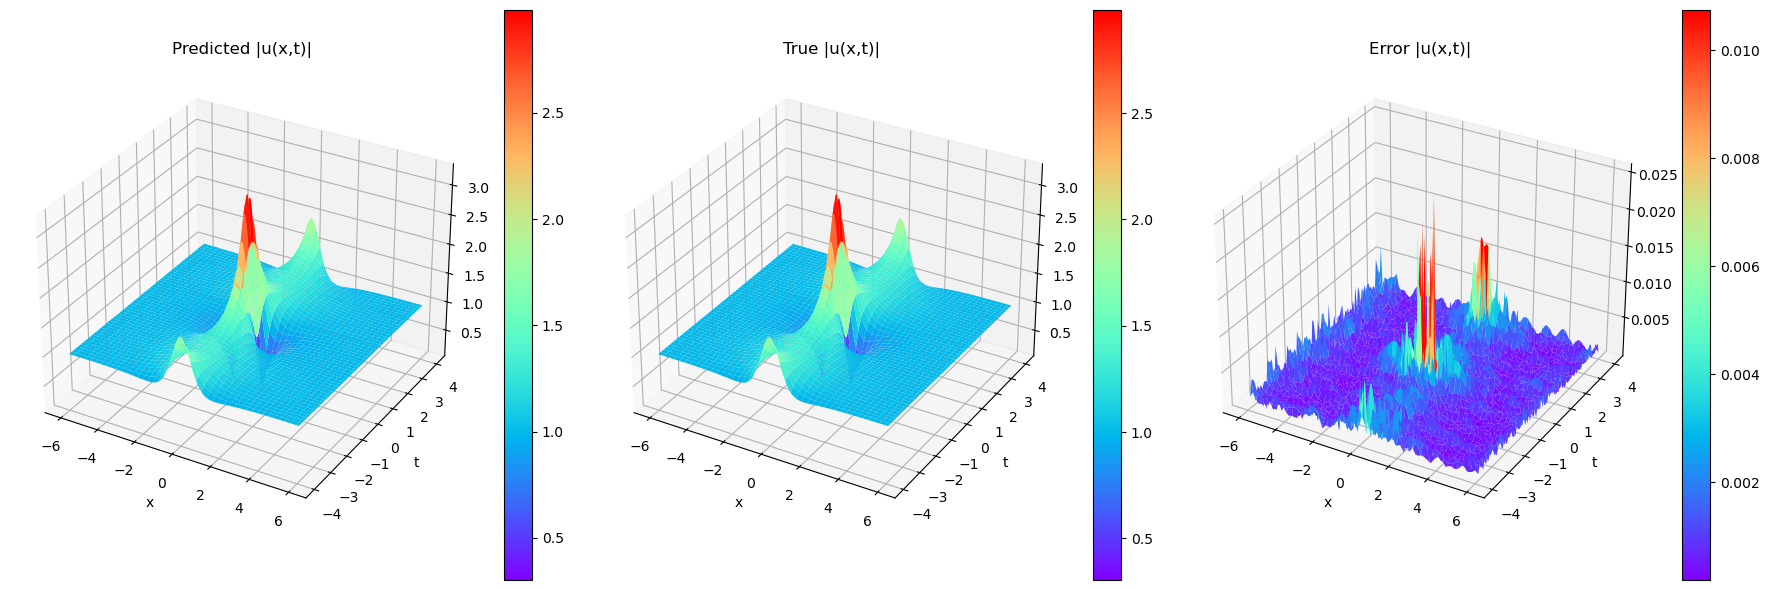

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# 假设你已经准备好这些数据
index_test = torch.randint(0, ntest, (1,))  # 获取随机的测试样本索引

# 获取预测值的实部和虚部
pred_real = pred[index_test, :, 0:t.shape[1] - 1]
pred_imag = pred[index_test, :, t.shape[1] - 1:]
pred_abs = np.sqrt(pred_real**2 + pred_imag**2)

# 获取真实解的实部和虚部
true_real = np.real(u[index_test, :, :])
true_imag = np.imag(u[index_test, :, :])
true_abs = np.sqrt(true_real**2 + true_imag**2)

# 计算误差：模的差异
error_abs = np.sqrt((pred_real - true_real)**2 + (pred_imag - true_imag)**2)

# 网格坐标
X, T = np.meshgrid(x.squeeze(), t.squeeze()[1:], indexing='ij')  # shape: (256, 99)

# 创建一个新的图形，包含三个子图
fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': '3d'})

# 绘制预测解的模
ax1 = axs[0]
surf1 = ax1.plot_surface(X, T, pred_abs, cmap='rainbow')
ax1.set_title("Predicted |u(x,t)|")
ax1.set_xlabel("x")
ax1.set_ylabel("t")
fig.colorbar(surf1, ax=ax1)

# 绘制真实解的模
ax2 = axs[1]
surf2 = ax2.plot_surface(X, T, true_abs, cmap='rainbow')
ax2.set_title("True |u(x,t)|")
ax2.set_xlabel("x")
ax2.set_ylabel("t")
fig.colorbar(surf2, ax=ax2)

# 绘制误差图像
ax3 = axs[2]
surf3 = ax3.plot_surface(X, T, error_abs, cmap='rainbow')
ax3.set_title("Error |u(x,t)|")
ax3.set_xlabel("x")
ax3.set_ylabel("t")
fig.colorbar(surf3, ax=ax3)

# 调整布局
plt.tight_layout()
plt.show()


